# Load wavefront sensing and control libraries

In [1]:
# import sys
import os
# change below to local path
os.chdir('/home/groot/HCIL/FPWCpy/')

In [2]:
import scipy.io as sio
import scipy as sp
import numpy as np
import SPLC_model as splc
import VORTEX_model as vortex
import systemID as sysid
import estimation as est
import sensing
import detector
import helper_function as hp
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
plt.ion()

# Define some helper functions

In [3]:
def EFC(x, G, weight, alpha):
    # Electric Field Conjugation Controller
    M = np.zeros((G.shape[1], G.shape[1]))
    Gx = np.zeros((G.shape[1], 1))
    for k in range(len(weight)):
        Gx += weight[k] * np.real(np.matmul(np.conj(G[:, :, k].T), x[:, k].reshape((-1, 1))))
        M += weight[k] * np.real(np.matmul(np.conj(G[:, :, k].T), G[:, :, k]))
    command = -np.real(np.matmul(np.linalg.inv(M + alpha*np.eye(G.shape[1])), Gx.reshape((-1, 1))))
    return command.reshape(G.shape[1])

In [4]:
def mis_registration(field, shift=[0.5, 0.5, 0]):
    # introduce image mis-registration errors
    out = sp.ndimage.shift(field.real, shift=shift) + 1j * sp.ndimage.shift(field.imag, shift=shift)
    return out

# Define the optical model, camera model, controller, estimator, probe policy and system identifier

In [5]:
# define the optical model
wavelength = 635e-9 * np.ones(1)
DM1gain = 5.06e-9 * np.ones((34, 34))
DM2gain = 6.27e-9 * np.ones((34, 34))
coronagraph_type = 'vortex'

model = vortex.Optical_Model(wavelength, DM1gain, DM2gain, wfe=True)
model_perfect = vortex.Optical_Model(wavelength, DM1gain, DM2gain, wfe=False)

# define the dark hole region
dh_ind1, dh_ind2 = hp.Compute_DH(model, dh_shape='circ', range_r=[3, 9], range_angle=30)

# compute the Jacobian matrices
# this may take a while (around 10-20 minutes)
G1, G2 = hp.Compute_Jacobian(model_perfect, dh_ind1, dh_ind2)
G = np.concatenate((G1, G2), axis=1)

In [7]:
# define the control parameters
Nitr = 50 # number of control iterations
n_trials = 1
n_act = G1.shape[1] # number of active actuators on the DM
n_pix = G1.shape[0] # number of pixels in the dark hole
weight = np.ones(len(wavelength)) # weights of different wavelengths used for EFC
alpha = 3e-7 # Tikhonov regularization parameters
img_number = 8 # number of probe images used for wavefront sensing
exp_time = 1 # camera exposure time for each image

In [8]:
# define the camera noise model
camera = detector.CCD(flux=2e9, readout_std=12, readout=True, photon=True, exp_time=exp_time)

In [9]:
# define the wavefront estimator
# params_values include the the Jacobian matrices and the noise coefficients for the state space model
# state transition: E_k = E_{k-1} + G u_k + w_k, var(w_k) =  Q0 + Q1 * mean(|G u_k|**2)
# observation: I_k = (E_k + p_k)**2 + n_k, p_k = G u_k^p, 
# var(n_k) = R0 + R1 * mean(I_k) + 4 * R2 * (Q0 + Q1 * mean(|p_k|**2)) * mean(I_k)
params_values = {}
params_values['G1'] = G1
params_values['G2'] = G2
params_values['Q0'] = 1e-12
params_values['Q1'] = 0.15
params_values['R0'] = 3.6e-17
params_values['R1'] = 5e-10
BPE_estimator = est.Batch_process(params_values)
# KF_estimator = est.Kalman_filter(params_values)

In [10]:
# define the probe (sensing) policy
sensor = sensing.Empirical_probe(model, params_values, img_number, 
                                pair_wise=True, probe_area=[1, 17, -17, 17], method='alter')

In [11]:
# define the system identifier for adaptive control
# in our system identifier, the parameters we want to identify is 
n_batch = 5 # the model parameters will be updated every "n_batch" steps
vl = sysid.linear_vl(params_values, img_number//2)

In [12]:
# define the data structure to save the control data
data_train = {}
data_train['u1'] = np.ones((n_act, Nitr))
data_train['u2'] = np.ones((n_act, Nitr))
data_train['u1p'] = np.ones((n_act, img_number, Nitr))
data_train['u2p'] = np.ones((n_act, img_number, Nitr))
data_train['I'] = np.ones((n_pix, img_number+1, Nitr))
data_train['time'] = np.zeros(Nitr)

# Start adaptive wavefront sensing control (WFSC) with mis-registration

In [13]:
contrast_set = []
n_trials = 5
for trial in range(n_trials):
    # start wavefront control
    u1 = np.zeros((34, 34))
    u2 = np.zeros((34, 34))
    u10 = u1
    u20 = u2
    contrast = np.zeros((Nitr, ))
    E_true = []
    for k in range(Nitr):
        # collect the unprobed image
        Ef = model.Propagate(u1, u2)
        Ef = mis_registration(Ef) # introduce image mis-registration
        Ef_vector = Ef[dh_ind1, dh_ind2, :]
        If_vector = np.abs(Ef_vector)**2
        If = camera.Add_noise(If_vector)
        contrast[k] = np.mean(If_vector)
        print('The contrast at step #{} is {}'.format(k, contrast[k]))
        E_true.append(Ef_vector)

        # generate the optimal probe commands
        # camera.set_exposure(np.max([1e-9/contrast[k], 1e-3]))
        # exp_time = camera.exp_time
        print('The exposure time at step #{} is {}'.format(k, exp_time))
        R_coef = [params_values['R0']/exp_time**2, params_values['R1']/exp_time+4*params_values['Q0'], 4*params_values['Q1']]
        u_p = sensor.Probe_command(contrast[k], k, index=1, R_coef=R_coef) # collect optimal probe command

        # collect the probe images
        If_p = np.empty((len(dh_ind1), len(wavelength), img_number), dtype=float)
        Ef_p_set = np.empty((len(dh_ind1), len(wavelength), img_number), dtype=complex)
        for i in range(u_p.shape[2]):
            # images with positive probes
            Ef_p = model.Propagate(u1+u_p[:, :, i], u2)
            Ef_p = mis_registration(Ef_p) # introduce image mis-registration
            Ef_p_vector = Ef_p[dh_ind1, dh_ind2, :]
            If_p_vector = np.abs(Ef_p_vector)**2
            If_p[:, :, 2*i] = camera.Add_noise(If_p_vector)
            Ef_p_set[:, :, 2*i] = Ef_p_vector
            print('The contrast of the No.{} postive image is {}'.format(i, np.mean(If_p_vector)))
            # images with negative probes
            Ef_p = model.Propagate(u1-u_p[:, :, i], u2)
            Ef_p = mis_registration(Ef_p) # introduce image mis-registration
            Ef_p_vector = Ef_p[dh_ind1, dh_ind2, :]
            If_p_vector = np.abs(Ef_p_vector)**2
            If_p[:, :, 2*i+1] = camera.Add_noise(If_p_vector)
            Ef_p_set[:, :, 2*i+1] = Ef_p_vector
            print('The contrast of the No.{} negative image is {}'.format(i, np.mean(If_p_vector)))

        # estimate the estimated electric field, mean and covariance
        u_p_vector = u_p[model.DMind1, model.DMind2, :]
        Ef_est, P_est = BPE_estimator.Estimate(If_p, u_p_vector, np.zeros(u_p_vector.shape), exp_time)

        # compute control command
        command = EFC(Ef_est, G, weight, alpha)
        u1[model.DMind1, model.DMind2] += command[:int(len(command)/2):]
        u2[model.DMind1, model.DMind2] += command[int(len(command)/2)::]

        # save the control data
        data_train['u1'][:, k] = command[0:n_act]
        data_train['u2'][:, k]= command[n_act::]
        for k_image in range(img_number):
            data_train['u1p'][:, k_image, k] = ((-1)**(k_image%2)) * u_p[model.DMind1, model.DMind2, k_image//2]
            data_train['u2p'][:, k_image, k] = np.zeros((n_act, ))
        data_train['I'][:, 0, k] = np.squeeze(If)
        data_train['I'][:, 1::, k] = np.squeeze(If_p)
        data_train['time'][k] = camera.exp_time


        if (k+1) % n_batch == 0: # update the model parameters every 5 control steps
            data_train_now = {}
            data_train_now['u1'] = data_train['u1'][:, k+1-n_batch:k+1]
            data_train_now['u2'] = data_train['u2'][:, k+1-n_batch:k+1]
            data_train_now['u1p'] = data_train['u1p'][:, :, k+1-n_batch:k+1]
            data_train_now['u2p'] = data_train['u2p'][:, :, k+1-n_batch:k+1]
            data_train_now['I'] = data_train['I'][:, :, k+1-n_batch:k+1]
            mse_list = vl.train_params(data_train_now, lr=1e-8, lr2=1e-3, epoch=30, 
                            params_trainable='all', print_flag=False)
            G1 = params_values['G1']
            G2 = params_values['G2']
            G = np.concatenate((G1, G2), axis=1)

    contrast_set.append(contrast) # save the contrast for each control trial

The contrast at step #0 is 0.0003585800011502816
The exposure time at step #0 is 1
The chosen probe contrast is 5.488781294296909e-07
The contrast of the No.0 postive image is 0.0003613012748353006
The contrast of the No.0 negative image is 0.0003569034029324806
The contrast of the No.1 postive image is 0.00036041079864143036
The contrast of the No.1 negative image is 0.000357792380677006
The contrast of the No.2 postive image is 0.0003611215282738848
The contrast of the No.2 negative image is 0.000357072004437879
The contrast of the No.3 postive image is 0.00035898892068292657
The contrast of the No.3 negative image is 0.00035920789298887984
The contrast at step #1 is 7.637787507182809e-05
The exposure time at step #1 is 1
The chosen probe contrast is 2.5341155273652306e-07
The contrast of the No.0 postive image is 7.639274999271127e-05
The contrast of the No.0 negative image is 7.697540932103273e-05
The contrast of the No.1 postive image is 7.657531058709248e-05
The contrast of the N

The contrast of the No.3 postive image is 5.439613652914326e-06
The contrast of the No.3 negative image is 5.4399782742302254e-06
initial MSE: 1.3589586903384097e-07
epoch 0 MSE: 1.3472330799668907e-07
Q1: 0.1454234830915899
epoch 1 MSE: 1.3355960852441183e-07
Q1: 0.14527812919120633
epoch 2 MSE: 1.3240508618915407e-07
Q1: 0.14513291796898592
epoch 3 MSE: 1.3125976271931976e-07
Q1: 0.14498786062135918
epoch 4 MSE: 1.3012356701150871e-07
Q1: 0.1448429530541435
epoch 5 MSE: 1.289964718637895e-07
Q1: 0.14469819346803334
epoch 6 MSE: 1.2787845167433823e-07
Q1: 0.14455358081460568
epoch 7 MSE: 1.267694812695353e-07
Q1: 0.14440911454740796
epoch 8 MSE: 1.2566953577251633e-07
Q1: 0.14426479451325683
epoch 9 MSE: 1.2457861895738232e-07
Q1: 0.14412062492586974
epoch 10 MSE: 1.2349669240033125e-07
Q1: 0.1439766049667186
epoch 11 MSE: 1.2242371820715138e-07
Q1: 0.14383273413867903
epoch 12 MSE: 1.2135965880064405e-07
Q1: 0.14368901210795723
epoch 13 MSE: 1.2030447666716608e-07
Q1: 0.1435454386013

The contrast of the No.2 negative image is 2.6070274008427136e-06
The contrast of the No.3 postive image is 2.6105447332052786e-06
The contrast of the No.3 negative image is 2.5999053410247584e-06
The contrast at step #17 is 2.540524246684968e-06
The exposure time at step #17 is 1
The chosen probe contrast is 4.8995509744184205e-08
The contrast of the No.0 postive image is 2.585489739654338e-06
The contrast of the No.0 negative image is 2.6002755355367036e-06
The contrast of the No.1 postive image is 2.595160021701072e-06
The contrast of the No.1 negative image is 2.592615853691131e-06
The contrast of the No.2 postive image is 2.5944830886333663e-06
The contrast of the No.2 negative image is 2.59073119648292e-06
The contrast of the No.3 postive image is 2.594351507001045e-06
The contrast of the No.3 negative image is 2.5891271983160247e-06
The contrast at step #18 is 2.3899953403941672e-06
The exposure time at step #18 is 1
The chosen probe contrast is 4.756273547118926e-08
The contras

epoch 16 MSE: 3.54606479663223e-09
Q1: 0.13080316970845354
epoch 17 MSE: 3.5183298625032053e-09
Q1: 0.13067249207850798
epoch 18 MSE: 3.4909020141885726e-09
Q1: 0.1305419513331731
epoch 19 MSE: 3.4637782808768962e-09
Q1: 0.1304115473668619
epoch 20 MSE: 3.43695569476461e-09
Q1: 0.13028128011657578
epoch 21 MSE: 3.4104316466769267e-09
Q1: 0.13015115132280805
epoch 22 MSE: 3.384203119244564e-09
Q1: 0.130021160804438
epoch 23 MSE: 3.3582670993662565e-09
Q1: 0.1298913084408041
epoch 24 MSE: 3.3326205738474737e-09
Q1: 0.1297615941666555
epoch 25 MSE: 3.307260517348286e-09
Q1: 0.12963201793453644
epoch 26 MSE: 3.2821838871869586e-09
Q1: 0.12950257971604268
epoch 27 MSE: 3.2573878803703723e-09
Q1: 0.12937328088008135
epoch 28 MSE: 3.2328693764350765e-09
Q1: 0.12924412134028188
epoch 29 MSE: 3.2086252267862647e-09
Q1: 0.12911510104192167
The contrast at step #25 is 1.3437059881267952e-06
The exposure time at step #25 is 1
The chosen probe contrast is 3.716170414152349e-08
The contrast of the N

The contrast of the No.1 postive image is 6.117929598959496e-07
The contrast of the No.1 negative image is 6.12374992537102e-07
The contrast of the No.2 postive image is 6.110566762027302e-07
The contrast of the No.2 negative image is 6.117431232061933e-07
The contrast of the No.3 postive image is 6.115290003998056e-07
The contrast of the No.3 negative image is 6.103222270442545e-07
The contrast at step #34 is 5.278210149937408e-07
The exposure time at step #34 is 1
The chosen probe contrast is 2.4547794342312116e-08
The contrast of the No.0 postive image is 5.535816890421064e-07
The contrast of the No.0 negative image is 5.556657393386302e-07
The contrast of the No.1 postive image is 5.544198506481526e-07
The contrast of the No.1 negative image is 5.555391605166974e-07
The contrast of the No.2 postive image is 5.544284545005107e-07
The contrast of the No.2 negative image is 5.549990218870086e-07
The contrast of the No.3 postive image is 5.553930013613792e-07
The contrast of the No.3 n

The contrast of the No.1 postive image is 2.8569005215154017e-07
The contrast of the No.1 negative image is 2.8404237506848466e-07
The contrast of the No.2 postive image is 2.853241667560553e-07
The contrast of the No.2 negative image is 2.8333011989744347e-07
The contrast of the No.3 postive image is 2.8398296789568265e-07
The contrast of the No.3 negative image is 2.8411385802976753e-07
The contrast at step #41 is 2.324160050213947e-07
The exposure time at step #41 is 1
The chosen probe contrast is 1.801188265110264e-08
The contrast of the No.0 postive image is 2.5397532314325474e-07
The contrast of the No.0 negative image is 2.5113527921870664e-07
The contrast of the No.1 postive image is 2.530254116602918e-07
The contrast of the No.1 negative image is 2.52914679252724e-07
The contrast of the No.2 postive image is 2.532094864434844e-07
The contrast of the No.2 negative image is 2.517512429491022e-07
The contrast of the No.3 postive image is 2.5201088963574115e-07
The contrast of the

epoch 2 MSE: 2.871074059148824e-11
Q1: 0.11417591214124467
epoch 3 MSE: 2.8500390338019018e-11
Q1: 0.11406179302080743
epoch 4 MSE: 2.8291963793026143e-11
Q1: 0.11394779015881636
epoch 5 MSE: 2.808544530181965e-11
Q1: 0.11383390180468018
epoch 6 MSE: 2.7880811656435346e-11
Q1: 0.11372012680370612
epoch 7 MSE: 2.767804333153809e-11
Q1: 0.11360646440108665
epoch 8 MSE: 2.747712777831391e-11
Q1: 0.11349291415627186
epoch 9 MSE: 2.72780618020372e-11
Q1: 0.11337947906947538
epoch 10 MSE: 2.7080834883621477e-11
Q1: 0.11326615818648919
epoch 11 MSE: 2.6885435524510055e-11
Q1: 0.11315295081080821
epoch 12 MSE: 2.669185149327349e-11
Q1: 0.11303985637925404
epoch 13 MSE: 2.650007048423639e-11
Q1: 0.11292687438111566
epoch 14 MSE: 2.631008077818551e-11
Q1: 0.1128140044475547
epoch 15 MSE: 2.612187474909632e-11
Q1: 0.11270124837958793
epoch 16 MSE: 2.5935441187266283e-11
Q1: 0.11258860564225397
epoch 17 MSE: 2.5750769179824192e-11
Q1: 0.1124760757624556
epoch 18 MSE: 2.556784794978481e-11
Q1: 0.11

The contrast of the No.0 postive image is 4.556838947017348e-06
The contrast of the No.0 negative image is 4.52278186649761e-06
The contrast of the No.1 postive image is 4.547201680052108e-06
The contrast of the No.1 negative image is 4.533951698631631e-06
The contrast of the No.2 postive image is 4.538045644826415e-06
The contrast of the No.2 negative image is 4.5409626823763776e-06
The contrast of the No.3 postive image is 4.543003345717789e-06
The contrast of the No.3 negative image is 4.534864369645811e-06
The contrast at step #8 is 3.4599757860522653e-06
The exposure time at step #8 is 1
The chosen probe contrast is 6.423121888967728e-08
The contrast of the No.0 postive image is 3.525341721044441e-06
The contrast of the No.0 negative image is 3.5400315948278257e-06
The contrast of the No.1 postive image is 3.540222765535639e-06
The contrast of the No.1 negative image is 3.5280871120884366e-06
The contrast of the No.2 postive image is 3.544173620225003e-06
The contrast of the No.2 

epoch 20 MSE: 2.043829690216519e-09
Q1: 0.10248993088684752
epoch 21 MSE: 2.0232075280584152e-09
Q1: 0.10238753492528173
epoch 22 MSE: 2.0028397226406865e-09
Q1: 0.10228524544056702
epoch 23 MSE: 1.9827251402924382e-09
Q1: 0.10218306224968221
epoch 24 MSE: 1.9628625895173527e-09
Q1: 0.10208098521448894
epoch 25 MSE: 1.9432507936730573e-09
Q1: 0.10197901421215361
epoch 26 MSE: 1.923888373278223e-09
Q1: 0.10187714913615728
epoch 27 MSE: 1.9047740354831137e-09
Q1: 0.10177539098100682
epoch 28 MSE: 1.885906139936171e-09
Q1: 0.10167373959733068
epoch 29 MSE: 1.8672829217725053e-09
Q1: 0.10157219486204659
The contrast at step #15 is 9.061207506775237e-07
The exposure time at step #15 is 1
The chosen probe contrast is 3.4823081030516694e-08
The contrast of the No.0 postive image is 9.486920990985136e-07
The contrast of the No.0 negative image is 9.436683360164991e-07
The contrast of the No.1 postive image is 9.477424917116154e-07
The contrast of the No.1 negative image is 9.452027884880879e-0

The contrast of the No.3 negative image is 2.855967782329418e-07
The contrast at step #24 is 2.2348856468462516e-07
The exposure time at step #24 is 1
The chosen probe contrast is 1.9416036584037272e-08
The contrast of the No.0 postive image is 2.472495443398844e-07
The contrast of the No.0 negative image is 2.4490825140889287e-07
The contrast of the No.1 postive image is 2.4609364395866494e-07
The contrast of the No.1 negative image is 2.468977826469534e-07
The contrast of the No.2 postive image is 2.450165010169637e-07
The contrast of the No.2 negative image is 2.4676637388865964e-07
The contrast of the No.3 postive image is 2.4458973382391025e-07
The contrast of the No.3 negative image is 2.4646073469634744e-07
initial MSE: 1.569192350325931e-10
epoch 0 MSE: 1.5553599242132636e-10
Q1: 0.09847252980109206
epoch 1 MSE: 1.5416590352196008e-10
Q1: 0.09837410407329218
epoch 2 MSE: 1.528091338381879e-10
Q1: 0.09827577443712808
epoch 3 MSE: 1.5146588624079063e-10
Q1: 0.09817754827062193
ep

The contrast of the No.3 postive image is 1.0019067836845357e-07
The contrast of the No.3 negative image is 9.9724816559155e-08
The contrast at step #31 is 6.936750922643595e-08
The exposure time at step #31 is 1
The chosen probe contrast is 1.3823981251364999e-08
The contrast of the No.0 postive image is 8.561789269582331e-08
The contrast of the No.0 negative image is 8.559786128122629e-08
The contrast of the No.1 postive image is 8.578695425154689e-08
The contrast of the No.1 negative image is 8.56682317420839e-08
The contrast of the No.2 postive image is 8.55677159785848e-08
The contrast of the No.2 negative image is 8.551947098092424e-08
The contrast of the No.3 postive image is 8.394276750673388e-08
The contrast of the No.3 negative image is 8.699619916193858e-08
The contrast at step #32 is 5.722109135616015e-08
The exposure time at step #32 is 1
The chosen probe contrast is 1.321423967038044e-08
The contrast of the No.0 postive image is 7.348686543073688e-08
The contrast of the N

epoch 6 MSE: 3.3363460639714115e-12
Q1: 0.0907185978138397
epoch 7 MSE: 3.326638291334743e-12
Q1: 0.09080926413779303
epoch 8 MSE: 3.317015034810452e-12
Q1: 0.09089999536372778
epoch 9 MSE: 3.307476275682868e-12
Q1: 0.09099078559633621
epoch 10 MSE: 3.2980216448570072e-12
Q1: 0.09108163202682874
epoch 11 MSE: 3.2886507653059164e-12
Q1: 0.09117253157321793
epoch 12 MSE: 3.2793632447335645e-12
Q1: 0.09126348097739212
epoch 13 MSE: 3.2701586832333373e-12
Q1: 0.09135447686813934
epoch 14 MSE: 3.2610366958862855e-12
Q1: 0.09144551568734668
epoch 15 MSE: 3.2519970834737814e-12
Q1: 0.09153659204815781
epoch 16 MSE: 3.2430394701075465e-12
Q1: 0.09162770236894273
epoch 17 MSE: 3.2341634949693315e-12
Q1: 0.09171884294230039
epoch 18 MSE: 3.225368807385521e-12
Q1: 0.0918100099078593
epoch 19 MSE: 3.216655054955446e-12
Q1: 0.09190119929043856
epoch 20 MSE: 3.2080218765646785e-12
Q1: 0.09199240700093242
epoch 21 MSE: 3.1994690130876255e-12
Q1: 0.09208362759918994
epoch 22 MSE: 3.1909960588364334e-1

The contrast of the No.1 negative image is 1.646802525627919e-08
The contrast of the No.2 postive image is 1.6153654376138456e-08
The contrast of the No.2 negative image is 1.6597557187749252e-08
The contrast of the No.3 postive image is 1.608614572525753e-08
The contrast of the No.3 negative image is 1.6573052764014254e-08
The contrast at step #48 is 4.195159352675338e-09
The exposure time at step #48 is 1
The chosen probe contrast is 9.981867287833312e-09
The contrast of the No.0 postive image is 1.5616311057414288e-08
The contrast of the No.0 negative image is 1.5661602817332932e-08
The contrast of the No.1 postive image is 1.573067457437088e-08
The contrast of the No.1 negative image is 1.6001709568564136e-08
The contrast of the No.2 postive image is 1.5413068183643723e-08
The contrast of the No.2 negative image is 1.567813136421874e-08
The contrast of the No.3 postive image is 1.5323585602609287e-08
The contrast of the No.3 negative image is 1.538181941009733e-08
The contrast at s

epoch 24 MSE: 5.940511274098916e-06
Q1: 0.09610623630132951
epoch 25 MSE: 5.896829893574018e-06
Q1: 0.09601025145218632
epoch 26 MSE: 5.853464616703122e-06
Q1: 0.09591436759122716
epoch 27 MSE: 5.810414002309793e-06
Q1: 0.09581858568812382
epoch 28 MSE: 5.7676760576625455e-06
Q1: 0.09572290563483053
epoch 29 MSE: 5.725248750236072e-06
Q1: 0.09562732734705652
The contrast at step #5 is 6.042917066795349e-06
The exposure time at step #5 is 1
The chosen probe contrast is 8.975719174044661e-08
The contrast of the No.0 postive image is 6.139673000808757e-06
The contrast of the No.0 negative image is 6.145865908446509e-06
The contrast of the No.1 postive image is 6.1296672050319885e-06
The contrast of the No.1 negative image is 6.152091830849388e-06
The contrast of the No.2 postive image is 6.144781051550927e-06
The contrast of the No.2 negative image is 6.143160930854556e-06
The contrast of the No.3 postive image is 6.139808719507266e-06
The contrast of the No.3 negative image is 6.15203452

The contrast of the No.0 postive image is 5.930947941138767e-07
The contrast of the No.0 negative image is 5.868589870206188e-07
The contrast of the No.1 postive image is 5.920491693332722e-07
The contrast of the No.1 negative image is 5.874765271434324e-07
The contrast of the No.2 postive image is 5.934934124667683e-07
The contrast of the No.2 negative image is 5.868494690708631e-07
The contrast of the No.3 postive image is 5.906234939052506e-07
The contrast of the No.3 negative image is 5.903739097391906e-07
initial MSE: 9.711644641750932e-10
epoch 0 MSE: 9.605562707399403e-10
Q1: 0.09270884756130783
epoch 1 MSE: 9.50037450614891e-10
Q1: 0.09261618274574401
epoch 2 MSE: 9.396059977303645e-10
Q1: 0.09252360834599502
epoch 3 MSE: 9.292627631377966e-10
Q1: 0.09243113128653566
epoch 4 MSE: 9.19006952211632e-10
Q1: 0.09233874874587239
epoch 5 MSE: 9.088383439330383e-10
Q1: 0.09224645936750032
epoch 6 MSE: 8.987572646471699e-10
Q1: 0.09215426227559254
epoch 7 MSE: 8.887642435770007e-10
Q1:

The contrast of the No.0 postive image is 1.5584394810347966e-07
The contrast of the No.0 negative image is 1.5599125938890456e-07
The contrast of the No.1 postive image is 1.5474228683618547e-07
The contrast of the No.1 negative image is 1.562662391308265e-07
The contrast of the No.2 postive image is 1.560956892765294e-07
The contrast of the No.2 negative image is 1.5607897349551852e-07
The contrast of the No.3 postive image is 1.5769330712059802e-07
The contrast of the No.3 negative image is 1.554410155821507e-07
The contrast at step #22 is 1.0617654120595324e-07
The exposure time at step #22 is 1
The chosen probe contrast is 1.600158630431622e-08
The contrast of the No.0 postive image is 1.2311525772921792e-07
The contrast of the No.0 negative image is 1.2608529089282985e-07
The contrast of the No.1 postive image is 1.2329983346211778e-07
The contrast of the No.1 negative image is 1.256232272175471e-07
The contrast of the No.2 postive image is 1.2459884428407434e-07
The contrast of 

epoch 10 MSE: 4.180342989889762e-12
Q1: 0.08575081972249603
epoch 11 MSE: 4.16411170545782e-12
Q1: 0.08583599377519471
epoch 12 MSE: 4.1480360957502024e-12
Q1: 0.08592113294058176
epoch 13 MSE: 4.1321155684196945e-12
Q1: 0.08600622459941247
epoch 14 MSE: 4.116349488991142e-12
Q1: 0.08609125542929585
epoch 15 MSE: 4.100737482293682e-12
Q1: 0.08617620985089505
epoch 16 MSE: 4.0852788247808035e-12
Q1: 0.0862610733995254
epoch 17 MSE: 4.069972799953599e-12
Q1: 0.08634583089599242
epoch 18 MSE: 4.054818712499944e-12
Q1: 0.08643046639768444
epoch 19 MSE: 4.039815885600179e-12
Q1: 0.08651496321036253
epoch 20 MSE: 4.0249636601754835e-12
Q1: 0.08659930386514667
epoch 21 MSE: 4.010261589699832e-12
Q1: 0.08668346895334472
epoch 22 MSE: 3.99570901113939e-12
Q1: 0.08676743951438592
epoch 23 MSE: 3.981305268376948e-12
Q1: 0.08685119572813575
epoch 24 MSE: 3.967049706110655e-12
Q1: 0.08693471689410884
epoch 25 MSE: 3.9529416607344376e-12
Q1: 0.0870179814324011
epoch 26 MSE: 3.938980456375807e-12
Q1:

The contrast of the No.3 negative image is 1.2874054323219665e-08
The contrast at step #38 is 1.2095765622869909e-09
The exposure time at step #38 is 1
The chosen probe contrast is 1.0084276490206266e-08
The contrast of the No.0 postive image is 1.2393393255085628e-08
The contrast of the No.0 negative image is 1.2672879870243691e-08
The contrast of the No.1 postive image is 1.2428218454476675e-08
The contrast of the No.1 negative image is 1.2461080019410303e-08
The contrast of the No.2 postive image is 1.2657211478894619e-08
The contrast of the No.2 negative image is 1.2504283244072808e-08
The contrast of the No.3 postive image is 1.2741000925617612e-08
The contrast of the No.3 negative image is 1.2681580722753773e-08
The contrast at step #39 is 9.265695529751015e-10
The exposure time at step #39 is 1
The chosen probe contrast is 1.0064612537838897e-08
The contrast of the No.0 postive image is 1.2039011634522591e-08
The contrast of the No.0 negative image is 1.2481610344961553e-08
The 

epoch 28 MSE: 1.2484817688882017e-12
Q1: 0.09545720160220371
epoch 29 MSE: 1.2482617338499145e-12
Q1: 0.09555201766419125
The contrast at step #45 is 4.618128269389855e-10
The exposure time at step #45 is 1
The chosen probe contrast is 9.73645237831425e-09
The contrast of the No.0 postive image is 1.1064905027367209e-08
The contrast of the No.0 negative image is 1.1164835852731007e-08
The contrast of the No.1 postive image is 1.0686902733727532e-08
The contrast of the No.1 negative image is 1.1081069315078262e-08
The contrast of the No.2 postive image is 1.0998318860696283e-08
The contrast of the No.2 negative image is 1.1366153760582817e-08
The contrast of the No.3 postive image is 1.1506252258731468e-08
The contrast of the No.3 negative image is 1.1399975904471229e-08
The contrast at step #46 is 4.821096042799101e-10
The exposure time at step #46 is 1
The chosen probe contrast is 9.73782672525673e-09
The contrast of the No.0 postive image is 1.1016386874473557e-08
The contrast of the

The contrast of the No.2 postive image is 9.125170210611088e-06
The contrast of the No.2 negative image is 9.15067628248968e-06
The contrast of the No.3 postive image is 9.163742806252744e-06
The contrast of the No.3 negative image is 9.116586984773132e-06
initial MSE: 4.334755371286582e-06
epoch 0 MSE: 4.301325315617806e-06
Q1: 0.09835604696860356
epoch 1 MSE: 4.268134950562539e-06
Q1: 0.09825773785196107
epoch 2 MSE: 4.235184111156996e-06
Q1: 0.09815952501627516
epoch 3 MSE: 4.20247359736793e-06
Q1: 0.09806141594754504
epoch 4 MSE: 4.170000878265331e-06
Q1: 0.09796340779043211
epoch 5 MSE: 4.137764303366111e-06
Q1: 0.09786549924209646
epoch 6 MSE: 4.1057625904731236e-06
Q1: 0.09776768950790951
epoch 7 MSE: 4.073994655033066e-06
Q1: 0.09766997813309519
epoch 8 MSE: 4.042459498835146e-06
Q1: 0.09757236492921373
epoch 9 MSE: 4.011157058441451e-06
Q1: 0.0974748526618296
epoch 10 MSE: 3.980086201285912e-06
Q1: 0.09737744069326534
epoch 11 MSE: 3.949245945957682e-06
Q1: 0.09728012860362223

The contrast of the No.2 postive image is 7.557953136730256e-07
The contrast of the No.2 negative image is 7.662777438522008e-07
The contrast of the No.3 postive image is 7.596609234027999e-07
The contrast of the No.3 negative image is 7.631002190763139e-07
The contrast at step #12 is 5.642200528055747e-07
The exposure time at step #12 is 1
The chosen probe contrast is 2.939016016091741e-08
The contrast of the No.0 postive image is 5.931983788391386e-07
The contrast of the No.0 negative image is 6.000016091434327e-07
The contrast of the No.1 postive image is 5.953437113989059e-07
The contrast of the No.1 negative image is 5.96694058961865e-07
The contrast of the No.2 postive image is 5.928214659067524e-07
The contrast of the No.2 negative image is 6.009892710229801e-07
The contrast of the No.3 postive image is 5.96745707908797e-07
The contrast of the No.3 negative image is 5.983874837519109e-07
The contrast at step #13 is 4.3183544455115277e-07
The exposure time at step #13 is 1
The ch

epoch 14 MSE: 5.736370749074976e-11
Q1: 0.08864230498730237
epoch 15 MSE: 5.6959351268518915e-11
Q1: 0.08855369299567467
epoch 16 MSE: 5.655793007799927e-11
Q1: 0.088465168137914
epoch 17 MSE: 5.615944411158344e-11
Q1: 0.08837672993548402
epoch 18 MSE: 5.576389333374662e-11
Q1: 0.08828837798440231
epoch 19 MSE: 5.5371277241207404e-11
Q1: 0.08820011191658861
epoch 20 MSE: 5.498159478870504e-11
Q1: 0.08811193139755054
epoch 21 MSE: 5.45948495642308e-11
Q1: 0.08802383731848218
epoch 22 MSE: 5.4211038639861315e-11
Q1: 0.08793582927467379
epoch 23 MSE: 5.3830158565774314e-11
Q1: 0.08784790690711985
epoch 24 MSE: 5.345220538390296e-11
Q1: 0.08776006989911023
epoch 25 MSE: 5.30771745608881e-11
Q1: 0.08767231795076522
epoch 26 MSE: 5.2705061042342255e-11
Q1: 0.08758465077988636
epoch 27 MSE: 5.23358632259318e-11
Q1: 0.08749706905553192
epoch 28 MSE: 5.19695748092603e-11
Q1: 0.08740957246598996
epoch 29 MSE: 5.160618914134908e-11
Q1: 0.08732216072575916
The contrast at step #20 is 6.73467725778

The contrast of the No.0 negative image is 1.8743604589707844e-08
The contrast of the No.1 postive image is 1.8864293973567705e-08
The contrast of the No.1 negative image is 1.7789651464664514e-08
The contrast of the No.2 postive image is 1.8757811484545255e-08
The contrast of the No.2 negative image is 1.8498148876247784e-08
The contrast of the No.3 postive image is 1.8698885966214193e-08
The contrast of the No.3 negative image is 1.905542376808953e-08
The contrast at step #29 is 5.069566003895988e-09
The exposure time at step #29 is 1
The chosen probe contrast is 1.035857327057726e-08
The contrast of the No.0 postive image is 1.642164054376758e-08
The contrast of the No.0 negative image is 1.691434221094693e-08
The contrast of the No.1 postive image is 1.6201263271926248e-08
The contrast of the No.1 negative image is 1.6704047038239108e-08
The contrast of the No.2 postive image is 1.658049602984258e-08
The contrast of the No.2 negative image is 1.6918214204684792e-08
The contrast of 

The contrast of the No.0 postive image is 1.2404753013713468e-08
The contrast of the No.0 negative image is 1.2340511947027024e-08
The contrast of the No.1 postive image is 1.1928447476879764e-08
The contrast of the No.1 negative image is 1.270808385121373e-08
The contrast of the No.2 postive image is 1.245510174009845e-08
The contrast of the No.2 negative image is 1.2384549531074433e-08
The contrast of the No.3 postive image is 1.2564163082491247e-08
The contrast of the No.3 negative image is 1.2469986547601388e-08
The contrast at step #36 is 1.4689254993839984e-09
The exposure time at step #36 is 1
The chosen probe contrast is 9.813711573216246e-09
The contrast of the No.0 postive image is 1.2375590465649887e-08
The contrast of the No.0 negative image is 1.193584519018076e-08
The contrast of the No.1 postive image is 1.151439892364564e-08
The contrast of the No.1 negative image is 1.2414828236301798e-08
The contrast of the No.2 postive image is 1.2193499227117218e-08
The contrast of 

The contrast of the No.3 negative image is 1.1779802021887919e-08
initial MSE: 1.2072673018143783e-12
epoch 0 MSE: 1.2071148028504844e-12
Q1: 0.09836743540618782
epoch 1 MSE: 1.206963082138499e-12
Q1: 0.09846585218024428
epoch 2 MSE: 1.2068120509907248e-12
Q1: 0.09856436591057412
epoch 3 MSE: 1.2066617255174326e-12
Q1: 0.09866296766636232
epoch 4 MSE: 1.2065121096220992e-12
Q1: 0.09876165887627393
epoch 5 MSE: 1.206363196874456e-12
Q1: 0.09886043941800136
epoch 6 MSE: 1.206214979140318e-12
Q1: 0.09895930865973719
epoch 7 MSE: 1.206067448821731e-12
Q1: 0.09905826562596698
epoch 8 MSE: 1.2059205982477044e-12
Q1: 0.09915730906894579
epoch 9 MSE: 1.2057744233744602e-12
Q1: 0.09925643473138614
epoch 10 MSE: 1.2056289144707327e-12
Q1: 0.09935564179932807
epoch 11 MSE: 1.205484062194839e-12
Q1: 0.09945492923659667
epoch 12 MSE: 1.205339857900634e-12
Q1: 0.09955429589218955
epoch 13 MSE: 1.2051962936544908e-12
Q1: 0.09965374057054724
epoch 14 MSE: 1.2050533622443625e-12
Q1: 0.09975326195233407

The contrast of the No.3 postive image is 6.898436050085594e-05
The contrast of the No.3 negative image is 6.834590553798799e-05
The contrast at step #2 is 2.7163098545292858e-05
The exposure time at step #2 is 1
The chosen probe contrast is 1.813601924269664e-07
The contrast of the No.0 postive image is 2.74927313209143e-05
The contrast of the No.0 negative image is 2.7241111735783934e-05
The contrast of the No.1 postive image is 2.7572099626036427e-05
The contrast of the No.1 negative image is 2.716957147333938e-05
The contrast of the No.2 postive image is 2.7242581862100193e-05
The contrast of the No.2 negative image is 2.7497591444804015e-05
The contrast of the No.3 postive image is 2.716711607936005e-05
The contrast of the No.3 negative image is 2.7563373135265602e-05
The contrast at step #3 is 1.3855324288282996e-05
The exposure time at step #3 is 1
The chosen probe contrast is 1.2969014711004448e-07
The contrast of the No.0 postive image is 1.4010434374111585e-05
The contrast of

epoch 16 MSE: 1.135849897740914e-08
Q1: 0.09954021679884488
epoch 17 MSE: 1.1243677075961125e-08
Q1: 0.09944073172699555
epoch 18 MSE: 1.1129583849050104e-08
Q1: 0.09934134633239113
epoch 19 MSE: 1.101621957118673e-08
Q1: 0.09924206031125687
epoch 20 MSE: 1.090358452950492e-08
Q1: 0.09914287339448419
epoch 21 MSE: 1.0791680617449574e-08
Q1: 0.09904378668850511
epoch 22 MSE: 1.06805081885445e-08
Q1: 0.09894479983898738
epoch 23 MSE: 1.0570067836109868e-08
Q1: 0.09884591253996027
epoch 24 MSE: 1.0460360416887134e-08
Q1: 0.09874712452999788
epoch 25 MSE: 1.0351387023672366e-08
Q1: 0.09864843556359683
epoch 26 MSE: 1.0243148971667637e-08
Q1: 0.0985498454121518
epoch 27 MSE: 1.0135648912056149e-08
Q1: 0.09845135491383201
epoch 28 MSE: 1.0028888408970781e-08
Q1: 0.09835296380084946
epoch 29 MSE: 9.922869149725483e-09
Q1: 0.09825467183196358
The contrast at step #10 is 7.934018054297893e-07
The exposure time at step #10 is 1
The chosen probe contrast is 3.3302292858729476e-08
The contrast of 

The contrast of the No.1 negative image is 9.168931447911123e-08
The contrast of the No.2 postive image is 9.19456262741633e-08
The contrast of the No.2 negative image is 9.077573507427994e-08
The contrast of the No.3 postive image is 9.1809116160042e-08
The contrast of the No.3 negative image is 9.053479920970587e-08
The contrast at step #19 is 5.791036726091484e-08
The exposure time at step #19 is 1
The chosen probe contrast is 1.3073393165029717e-08
The contrast of the No.0 postive image is 7.197677979072871e-08
The contrast of the No.0 negative image is 7.237056391763007e-08
The contrast of the No.1 postive image is 7.254218235575109e-08
The contrast of the No.1 negative image is 7.174745556070186e-08
The contrast of the No.2 postive image is 7.362457429198046e-08
The contrast of the No.2 negative image is 7.11337488011075e-08
The contrast of the No.3 postive image is 7.294335984464296e-08
The contrast of the No.3 negative image is 7.195326760076383e-08
initial MSE: 2.9819770079488

The contrast of the No.1 postive image is 2.158364819569401e-08
The contrast of the No.1 negative image is 2.1649095511853548e-08
The contrast of the No.2 postive image is 2.1181510481899917e-08
The contrast of the No.2 negative image is 2.1432428393935082e-08
The contrast of the No.3 postive image is 2.0603032736447525e-08
The contrast of the No.3 negative image is 2.1513717555821858e-08
The contrast at step #26 is 7.571611800014363e-09
The exposure time at step #26 is 1
The chosen probe contrast is 1.0219146899114545e-08
The contrast of the No.0 postive image is 1.858639129424285e-08
The contrast of the No.0 negative image is 1.8858080279519977e-08
The contrast of the No.1 postive image is 1.9035471397346275e-08
The contrast of the No.1 negative image is 1.8753612578807185e-08
The contrast of the No.2 postive image is 1.8469580096626413e-08
The contrast of the No.2 negative image is 1.9138957275069215e-08
The contrast of the No.3 postive image is 1.8699996471489254e-08
The contrast o

epoch 0 MSE: 1.2605867579591526e-12
Q1: 0.09831078896250856
epoch 1 MSE: 1.2602232327973937e-12
Q1: 0.09840914955621322
epoch 2 MSE: 1.2598607519444256e-12
Q1: 0.09850760787185342
epoch 3 MSE: 1.2594993368178834e-12
Q1: 0.0986061553083252
epoch 4 MSE: 1.259138965104408e-12
Q1: 0.09870479361573639
epoch 5 MSE: 1.2587796186427036e-12
Q1: 0.0988035229916954
epoch 6 MSE: 1.2584212880625904e-12
Q1: 0.09890234312210716
epoch 7 MSE: 1.2580639676241014e-12
Q1: 0.09900125334677207
epoch 8 MSE: 1.2577076509484847e-12
Q1: 0.09910025273071787
epoch 9 MSE: 1.257352340609528e-12
Q1: 0.0991993373279081
epoch 10 MSE: 1.2569980260439905e-12
Q1: 0.09929850663113267
epoch 11 MSE: 1.256644697544261e-12
Q1: 0.09939775990810511
epoch 12 MSE: 1.256292346025189e-12
Q1: 0.09949709630871433
epoch 13 MSE: 1.255940962698227e-12
Q1: 0.09959651493518426
epoch 14 MSE: 1.2555905393148411e-12
Q1: 0.09969601476278946
epoch 15 MSE: 1.255241074516105e-12
Q1: 0.09979559284599483
epoch 16 MSE: 1.2548925599936274e-12
Q1: 0.

The contrast at step #42 is 7.131301997391675e-10
The exposure time at step #42 is 1
The chosen probe contrast is 9.336702381597955e-09
The contrast of the No.0 postive image is 1.0558789514396003e-08
The contrast of the No.0 negative image is 1.0482063551584483e-08
The contrast of the No.1 postive image is 1.0679429220844657e-08
The contrast of the No.1 negative image is 1.0698160234742513e-08
The contrast of the No.2 postive image is 1.0527049424256937e-08
The contrast of the No.2 negative image is 1.0697245116128222e-08
The contrast of the No.3 postive image is 1.0500313263084533e-08
The contrast of the No.3 negative image is 1.0457649336618676e-08
The contrast at step #43 is 6.712253002254064e-10
The exposure time at step #43 is 1
The chosen probe contrast is 9.333990285822812e-09
The contrast of the No.0 postive image is 1.0387044835090716e-08
The contrast of the No.0 negative image is 1.0518675439353623e-08
The contrast of the No.1 postive image is 1.0484900154631458e-08
The cont

epoch 18 MSE: 1.1884634349349835e-12
Q1: 0.10949819542906784
epoch 19 MSE: 1.1884258876252462e-12
Q1: 0.10960734779036754
epoch 20 MSE: 1.1883887406328945e-12
Q1: 0.10971656895364557
epoch 21 MSE: 1.1883519914801409e-12
Q1: 0.10982585568699088
epoch 22 MSE: 1.1883156365905507e-12
Q1: 0.10993520636547148
epoch 23 MSE: 1.1882796719081349e-12
Q1: 0.11004461931342246
epoch 24 MSE: 1.1882440929632655e-12
Q1: 0.11015409280841346
epoch 25 MSE: 1.188208894940694e-12
Q1: 0.11026362511282305
epoch 26 MSE: 1.1881740727568046e-12
Q1: 0.11037321447279151
epoch 27 MSE: 1.1881396214897712e-12
Q1: 0.11048285794832248
epoch 28 MSE: 1.1881055356676032e-12
Q1: 0.1105925538288738
epoch 29 MSE: 1.188071809717377e-12
Q1: 0.11070230037760445


# Visualize the adaptive control results

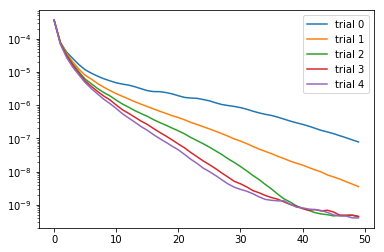

In [15]:
labels = ['trial {}'.format(trial) for trial in range(n_trials)]
plt.figure()
for trial in range(n_trials):
    plt.semilogy(contrast_set[trial])
plt.legend(labels)